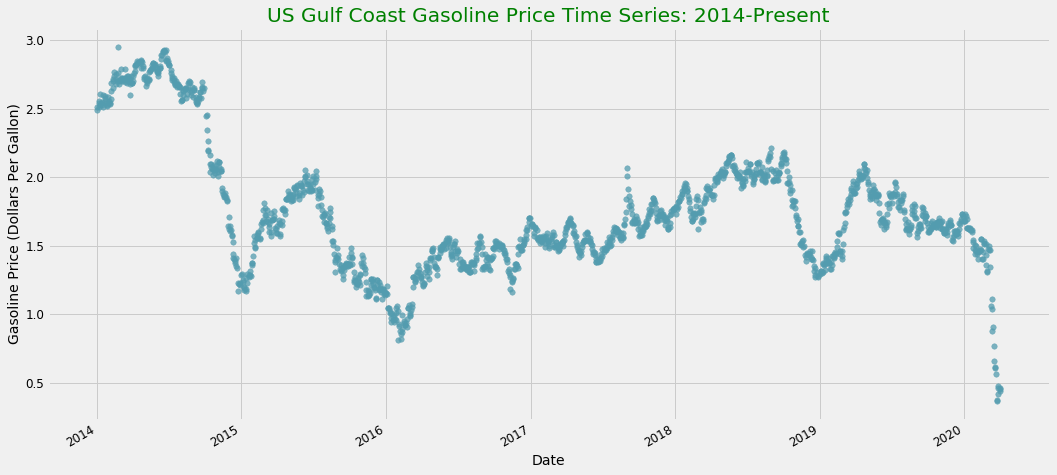

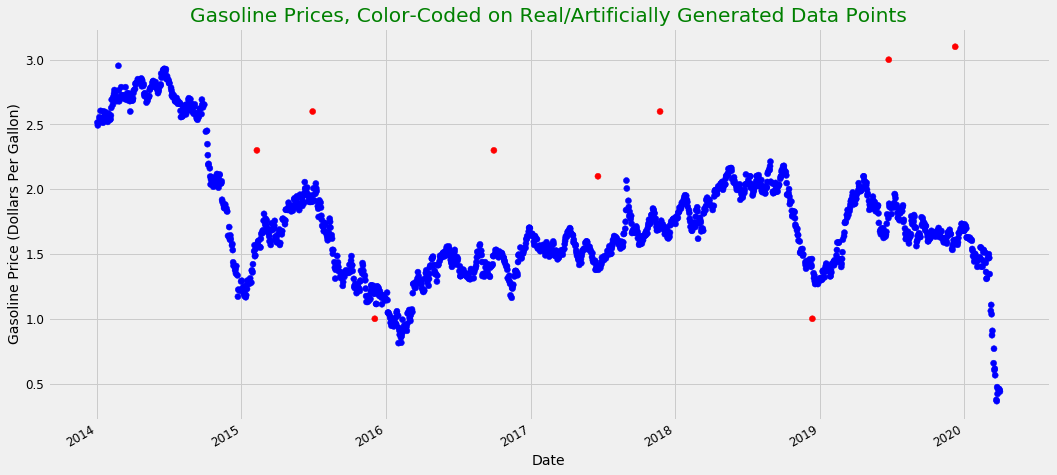

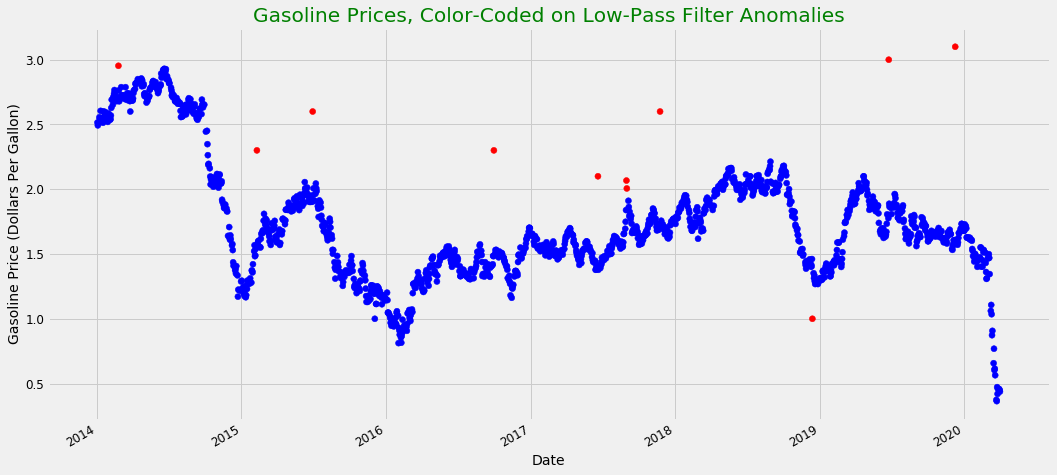

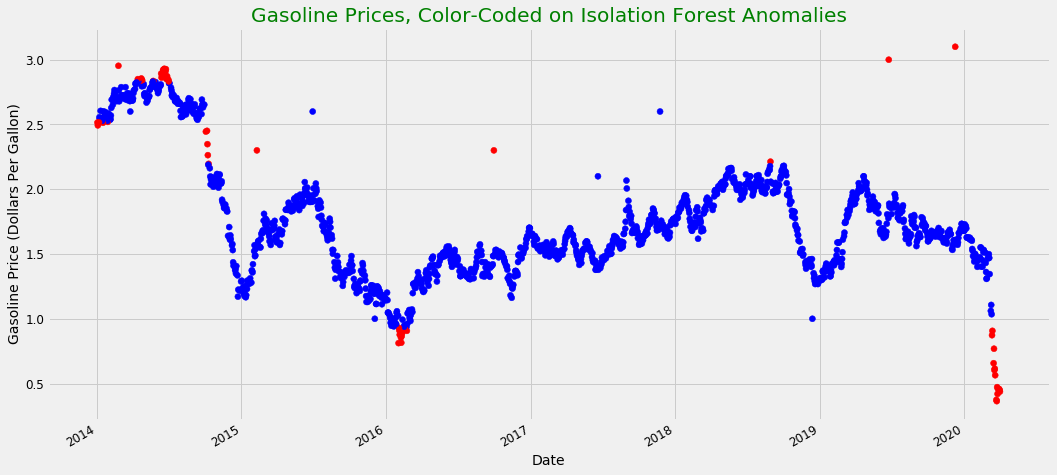

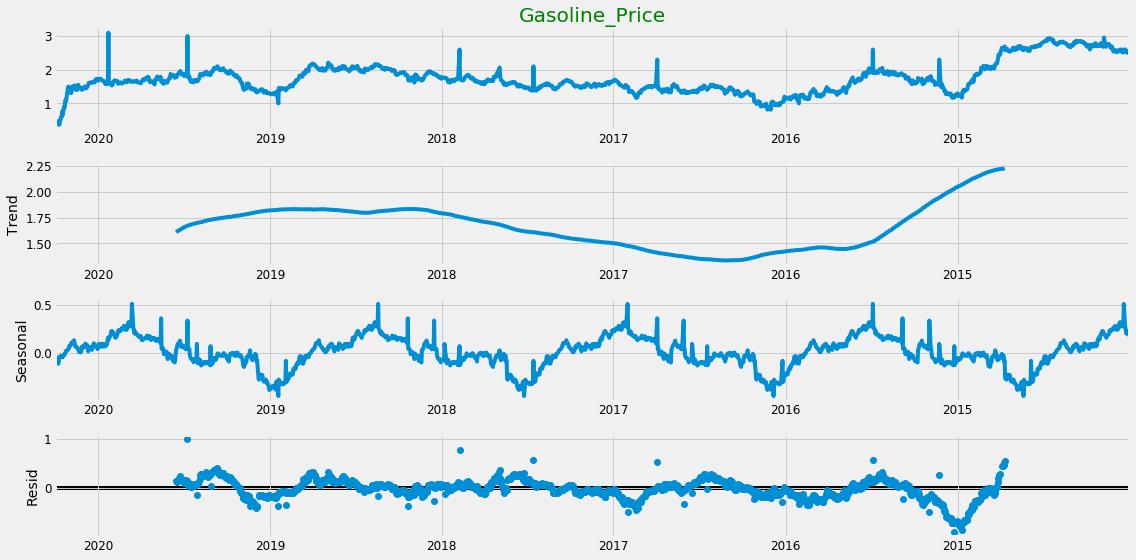

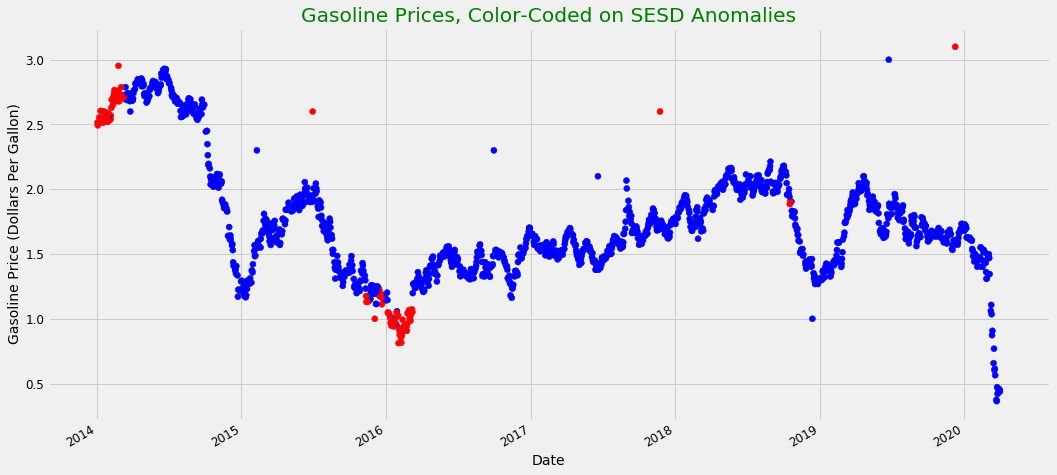

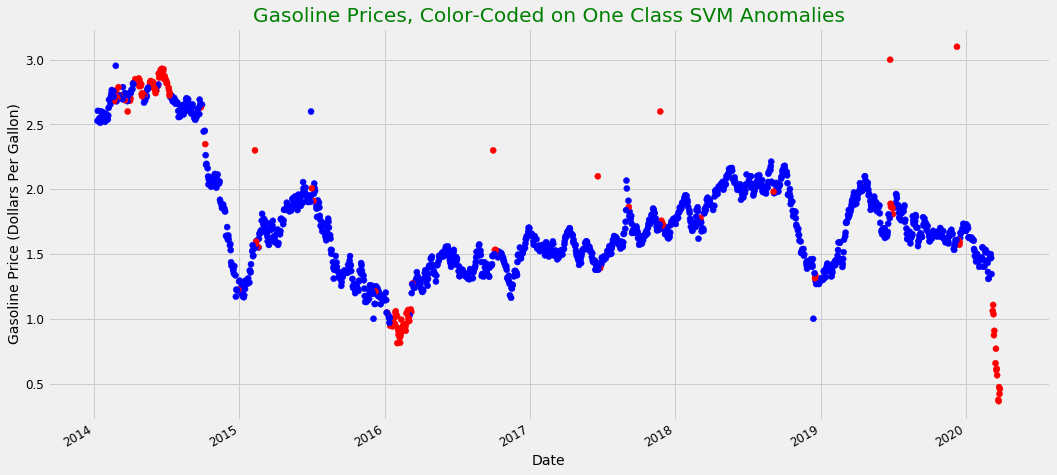

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import sesd
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn import svm
from matplotlib.pyplot import rcParams
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'G'
rcParams['figure.figsize'] = 16,8


def retrieve_time_series():
    ##Create a pandas dataframe from the retrieved time series
    df = pd.read_csv('U.S._Gulf_Coast_Conventional_Gasoline_Regular_Spot_Price_FOB_Daily.csv')
    return df

def scatterplot(x_data, y_data, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s = 30, color = '#539caf', alpha = 0.75)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()
    
def scatterplot_with_color_coding(x_data, y_data, color_code_column, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        color_code_column: Series. Column to color-code data points in scatterplot by.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, c=color_code_column, cmap=plt.get_cmap('bwr'))
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()

def low_pass_filter_anomaly_detection(df, 
                                      column_name, 
                                      number_of_stdevs_away_from_mean):
    """
    Implement a low-pass filter to detect anomalies in a time series, and save the filter outputs (True/False)
    to a new column in the dataframe.
    Arguments:
        df: Pandas dataframe
        column_name: strig. Name of the column that we want to detect anomalies in
        number_of_stdevs_away_from_mean: float. Number of standard deviations away from
        the mean that we want to flag anomalies at. For example, if number_of_stdevs_away_from_mean=2,
        then all data points more than 2 standard deviations away from the mean are flagged as 
        anomalies.
    Outputs:
        df: Pandas dataframe. Dataframe containing column for low pass filter anomalies (True/False)
    """
    #60-day rolling average
    df[column_name+'_Rolling_Average']=df[column_name].rolling(window=60, center=True).mean()
    #60-day standard deviation 
    df[column_name+'_Rolling_StDev']=df[column_name].rolling(window=60, center=True).std()
    #Detecct anomalies by determining how far away from the mean (in terms of standard devation)
    #each data point is
    df[column_name+'_Low_Pass_Filter_Anomaly']=(abs(df[column_name]-df[
                                column_name+'_Rolling_Average'])>(
                                number_of_stdevs_away_from_mean*df[
                                column_name+'_Rolling_StDev']))
    return df

def isolation_forest_anomaly_detection(df, 
                                       column_name, 
                                       outliers_fraction):
    """
    In this definition, time series anomalies are detected
    using an Isolation Forest algorithm.
    Arguments:
        df: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected Isolation Forest anomalies (True/False)
    """
    #Scale the column that we want to flag for anomalies
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(df[[column_name]])
    scaled_time_series = pd.DataFrame(np_scaled)
    # train isolation forest 
    model =  IsolationForest(contamination = outliers_fraction, behaviour='new')
    model.fit(scaled_time_series)
    #Generate column for Isolation Forest-detected anomalies
    isolation_forest_anomaly_column = column_name+'_Isolation_Forest_Anomaly'
    df[isolation_forest_anomaly_column] = model.predict(scaled_time_series)
    df[isolation_forest_anomaly_column] = df[isolation_forest_anomaly_column].map( {1: False, -1: True} )
    return df
    
def decompose_time_series(series, desired_frequency):
    """
    Perform STL decomposition on the time series.
    Arguments:
        series: Pandas series. Time series sequence that we sh to decompose.
        desired_frequency: Integer. Time frequency of the series. If we want to detect 
        a yearly trend, we'd set the value equal to 365.
    Outputs:
        Plot of time series STL decomposition.
    """
    result = seasonal_decompose(series, model='additive', freq=desired_frequency)
    result.plot()
    plt.show()
    
def sesd_anomaly_detection(dataframe, 
                           column_name, 
                           desired_frequency, 
                           max_anomalies,
                           alpha_level):
    """
    In this definition, time series anomalies are detected
    using the S-ESD algorithm.
    Arguments:
        dataframe: Pandas dataframe
        column_name: string. Name of the column that we want to detect anomalies in
        desired_frequency: Integer. Time frequency of the series. If we want to detect 
        a yearly trend, we'd set the value equal to 365.
        max_anomalies: Integer. Max number of anomalies to look for in the time series
        sequence.
        alpha_level:Significance level.
    Outputs:
        df: Pandas dataframe with column for detected S-ESD anomalies (True/False)
    """
    series=np.array(dataframe[column_name])
    #Fill any NaN values in the column with the mean
    col_mean = np.nanmean(series, axis=0)
    inds = np.where(np.isnan(series))
    series[inds] = col_mean
    #Implement SESD algorithm on the time series
    outliers_indices = sesd.seasonal_esd(series, 
                                         hybrid=False, 
                                         periodicity=desired_frequency,
                                         max_anomalies=max_anomalies, 
                                         alpha=alpha_level)
    
    #Create a column for SESD anomalies
    sesd_anomaly_column=column_name+'_SESD_Anomaly'
    #Create a detected anomaly column, and mark as False if normal, and True if anomalous
    dataframe[sesd_anomaly_column]=False
    dataframe.loc[dataframe.index.isin(outliers_indices), sesd_anomaly_column]=True
    return dataframe

def one_class_SVM_anomaly_detection(dataframe, columns_to_filter_by, outliers_fraction):
    """
    In this definition, time series anomalies are detected
    using a One Class SVM algorithm.
    Arguments:
        df: Pandas dataframe
        columns_to_filter_by: string, or list of strings. Name of the column(s) that 
        we want to use in the One Class SVM to detect time series anomalies
        outliers_fraction: float. Percentage of outliers allowed in the sequence.
    Outputs:
        df: Pandas dataframe with column for detected One Class SVM anomalies (True/False)
    """
    #Subset the dataframe by desired columns
    dataframe_filtered_columns=dataframe[columns_to_filter_by]
    #Transform the data using the fit_transform() function
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(dataframe_filtered_columns)
    scaled_dataframe = pd.DataFrame(np_scaled)
    #Remove any NaN's from the dataframe
    scaled_dataframe =scaled_dataframe.dropna()
    #Train the One Class SVM
    model = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
    model.fit(scaled_dataframe)
    #Create a column for the anomaly
    one_class_svm_anomaly_column='One_Class_SVM_Anomaly'
    scaled_dataframe[one_class_svm_anomaly_column] = pd.Series(model.predict(
                                                        scaled_dataframe)).map({1: False, -1: True})
    dataframe[one_class_svm_anomaly_column] = scaled_dataframe[one_class_svm_anomaly_column]
    return dataframe

if __name__ == "__main__" :
   
    gasoline_price_df=retrieve_time_series()
    gasoline_price_df.reset_index(level=0, inplace=True)
    
    #Rename the columns for easer analysis
    gasoline_price_df.rename(columns={'Day':'Date',
            'Series':'Gasoline_Price'}, 
            inplace=True)
    #Convert the Date column into a date object
    gasoline_price_df['Date']=pd.to_datetime(gasoline_price_df['Date'])
    #Subset to only include data going back to 2014
    gasoline_price_df=gasoline_price_df[(gasoline_price_df['Date']>='2014-01-01')]
    gasoline_price_df=gasoline_price_df.reset_index(drop=True)
        
    #Visualize anomalies using matplotlib function
    scatterplot(gasoline_price_df['Date'],
                gasoline_price_df['Gasoline_Price'], 
                'Date', 
                'Gasoline Price (Dollars Per Gallon)', 
                'US Gulf Coast Gasoline Price Time Series: 2014-Present')
    
    #Add in a couple anomalous data points for detection by the algorithm
    anomaly_dictionary={80: 3.1, 
                        200: 3,
                        333: 1,
                        600: 2.6,
                        710: 2.1,
                        890: 2.3,
                        1100: 1,
                        1211: 2.6,
                        1309: 2.3}
    #Set default for Artificially_Generated_Anomaly column to 0
    gasoline_price_df.loc[:,'Artificially_Generated_Anomaly']=0
    #Create fake anomaly values based on anomaly_dictionary
    for index, anomaly_value in anomaly_dictionary.items(): 
        gasoline_price_df.loc[index,'Gasoline_Price']=anomaly_value
        #Create a column to indicate Anomalies
        gasoline_price_df.loc[index,'Artificially_Generated_Anomaly']=1
    
    #Revisualize data with artificially generated anomalies
    scatterplot_with_color_coding(gasoline_price_df['Date'],
                                gasoline_price_df['Gasoline_Price'], 
                                gasoline_price_df['Artificially_Generated_Anomaly'],
                                'Date', 
                                'Gasoline Price (Dollars Per Gallon)', 
                                'Gasoline Prices, Color-Coded on Real/Artificially Generated Data Points')   

    #APPLY LOW PASS FILTER (ROLLING AVERAGE+ 2 Z-SCORE FILTER) TO DETECT ANOMALIES
    gasoline_price_df=low_pass_filter_anomaly_detection(df=gasoline_price_df, 
                                      column_name='Gasoline_Price', 
                                      number_of_stdevs_away_from_mean=3)
    #Re-plot time series with color coding for anomaly column
    scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['Gasoline_Price_Low_Pass_Filter_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Low-Pass Filter Anomalies')    
    

    #APPLY ISOLATION FOREST TO DETECT ANOMALIES
    gasoline_price_df=isolation_forest_anomaly_detection(df=gasoline_price_df, 
                                                         column_name='Gasoline_Price', 
                                                         outliers_fraction=.04)
    #Re-plot time series with color coding for anomaly column
    scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['Gasoline_Price_Isolation_Forest_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on Isolation Forest Anomalies') 
    
    #APPLY S-ESD ALGORITHM TO DETECT ANOMALIES
    #Decompose time series on a yearly interval
    #Set Date as index for the time series
    gasoline_price_df.index=gasoline_price_df['Date']
    decompose_time_series(series=gasoline_price_df['Gasoline_Price'], 
                          desired_frequency=365)
    #Implement the SESD algorithm on the time series
    #Reset index
    gasoline_price_df=gasoline_price_df.reset_index(drop=True)
    gasoline_price_df=sesd_anomaly_detection(dataframe=gasoline_price_df, 
                           column_name='Gasoline_Price', 
                           desired_frequency=365, 
                           max_anomalies=100,
                           alpha_level=1000)
    
    #Re-plot time series with color coding for anomaly column
    scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['Gasoline_Price_SESD_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on SESD Anomalies')    
    
    #APPLY ONE CLASS SVM ALGORITHM TO DETECT ANOMALIES
    #Create some columns to cluster against
    #Compare to mean of last 5 values and next 5 values
    gasoline_price_df['Gasoline_Price_Rolling_Average_6_pt']=gasoline_price_df['Gasoline_Price'].rolling(window=6, center=True).mean()
    #Calculate difference between gas price and rolling average value
    gasoline_price_df['Gasoline_Price_Diff_From_Rolling_Avg']=gasoline_price_df['Gasoline_Price']-gasoline_price_df['Gasoline_Price_Rolling_Average_6_pt']
    #Implement One Class SVM to time series
    gasoline_price_df=one_class_SVM_anomaly_detection(dataframe=gasoline_price_df, 
                                    columns_to_filter_by=['Gasoline_Price_Diff_From_Rolling_Avg',
                                                          'Gasoline_Price'], 
                                    outliers_fraction=.1)
    #Re-plot time series with color coding for anomaly column
    scatterplot_with_color_coding(gasoline_price_df['Date'],
                                  gasoline_price_df['Gasoline_Price'], 
                                  gasoline_price_df['One_Class_SVM_Anomaly'],
                                  'Date', 
                                  'Gasoline Price (Dollars Per Gallon)', 
                                  'Gasoline Prices, Color-Coded on One Class SVM Anomalies')